# Lea's AI experiment

I'm a DOS enthusiast and created a pixel rasterfont editor, called [pixelfedit](https://github.com/learosema/pixelfedit). You can edit raster fonts in the sizes 8x8, 8x14 or 8x16. These were commonly used in the EGA and VGA text modes. VGA graphics cards had the possibility to replace the character symbols with your own definitions, so I made this editor. It was originally a Pascal program written in 1996, now ported to the web.

As it is sometimes a bit tedious to draw all the characters, especially the ones you don't need to often, I want to add GenAI to help me with the tedious work.

So, A thing I want to try is to create a generative AI for raster font generation.
Let the user draw a couple characters and then let the AI predict a whole rest of the DOS-style character set.

You can use Tensorflow Pix2Pix for that.

## Getting started

A breakdown of building our generative pixelfont AI consists of these steps:

1. Data pipeline: Load your 512×256 training images, split them into (input, target) pairs
2. Generator: U-Net (classic encoder-decoder with skip connections)
3. Discriminator: PatchGAN (classifies real vs fake in patches, not full image)
4. Loss functions: Generator loss + L1 + adversarial; Discriminator loss
5. Training loop: Step-by-step with logging & checkpointing
6. Prediction: Run inference on masked inputs




## Generating training data

Before we can build the data pipeline, we'll need some training data.

For that, I have pixeled a few rasterfonts.
They are arranged in a 16x16 grid, with each character having a resolution of 8x8.
These three handpixeled fonts should do for now.

SmolSerif is very close to the font that is present in original VGA BIOS.
Boldie is a bold and playful font.
Scifi is a futuristic science-fiction style font, very much inspired by the font used in the game Rebelstar by Julian Gollop, 1985, who also built Laser Squad and later, the X-COM series.

![smolserif character set](./charsets/smolserif-8x8.png)
![boldie character set](./charsets/boldie-8x8.png)
![scifi character set](./charsets/scifi-8x8.png)

Important: before scraping any pixel font image for training, you will need to respect the license accordingly. The fonts in this repo are released under [CC-BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en). If you need a commercial license, reach out to Lea Rosema using one of her contact channels.

As a first step, lets open a font in python and display it using mathplotlib:


## Loading the images with python

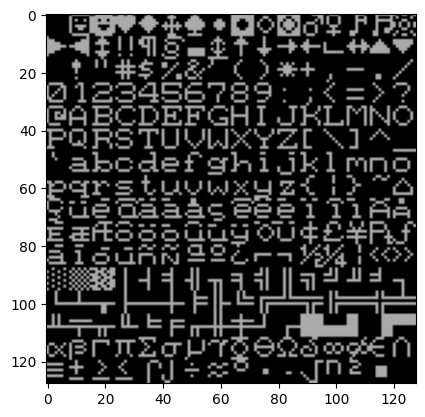

In [1]:
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np

img = Image.open('./charsets/smolserif-8x8.png').convert('F')
plt.imshow(img)

Ah, much better!

Next, let's prepare these images for training. Pix2pix expects 512x256 pixel image with 2 square-shaped images. The input image (A) on the left, the expected output on the right. Thus, we need to upscale our image and also paste it together accordingly.

As we want to teach our model to complete a character set, we put the complete character set on the right side of the training image. On the left side, there's a heavily reduced set where only a few characters are defined.


In [1]:
from font_pairgen import process_all_fonts
process_all_fonts("charsets", "training_pairs", num_variants=5)

Processing boldie-8x8.png
Processing scifi-8x8.png
Processing smolserif-8x8.png


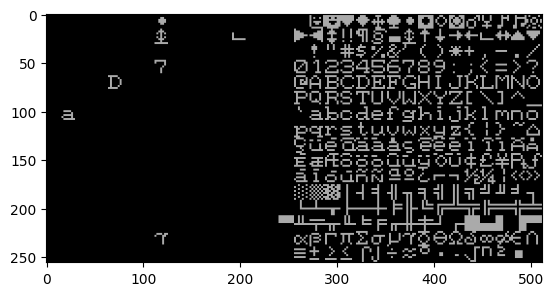

In [3]:
training_img = Image.open('./training_pairs/smolserif-8x8_v0.png').convert('F')
plt.imshow(training_img)

## Building the training dataset

As a next step, we'll train the model


In [6]:
from loader import load_dataset

train_ds = load_dataset("training_pairs", batch_size=8)

for inp, target in train_ds.take(1):
    print(inp.shape, target.shape)
    # Should be: (8, 256, 256, 1), (8, 256, 256, 1)


# Building the U-Net Generator

The [U-Net](https://en.wikipedia.org/wiki/U-Net) Generator is the brain that learns completing half-done character sets.
U-Net is a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) that was developed for image segmentation.

It takes our reduced font grid (left side, 256×256), and learns to fill in the missing characters.

It's called “U-Net” because of its U-shaped architecture:

- Downsampling path (encoder): captures context (what style, what shapes exist)
- Upsampling path (decoder): reconstructs the image
- Skip connections: copy details from encoder layers to decoder layers (so it doesn't forget fine structure like pixel edges)

Why it's perfect for this case:
The model needs to understand the visual style from the glyphs that are given, and then generate consistent glyphs for the rest.

The U-Net does exactly that — preserve detail where it’s given, and make the rest up with style-aware inference.

In [2]:
from generator import Generator

gen = Generator()
gen.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128, 128,  │      1,088 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64, 64,    │    131,584 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32, 32,    │    525,312 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 16, 16,    │  2,099,200 │ sequential_2[0][… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8, 8, 512) │  4,196,352 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 4, 4, 512) │  4,196,352 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 2, 2, 512) │  4,196,352 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 1, 1, 512) │  4,196,352 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 2, 2, 512) │  4,196,352 │ sequential_7[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2, 2,      │          0 │ sequential_8[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 4, 4, 512) │  8,390,656 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 4,      │          0 │ sequential_9[0][… │
│ (Concatenate)       │ 1024)             │            │ sequential_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 8, 8, 512) │  8,390,656 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 8, 8,      │          0 │ sequential_10[0]… │
│ (Concatenate)       │ 1024)             │            │ sequential_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 16, 16,    │  8,390,656 │ concatenate_2[0]… │
│ (Sequential)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ sequential_11[0]

 Total params: 54,419,777 (207.59 MB)

 Trainable params: 54,408,897 (207.55 MB)

 Non-trainable params: 10,880 (42.50 KB)

# Testing the Generator

The generator's job is to generate glyphs. We can test what the output of the generator looks like:



Input shape: (1, 256, 256, 1)
Target shape: (1, 256, 256, 1)
Generated shape: (1, 256, 256, 1)


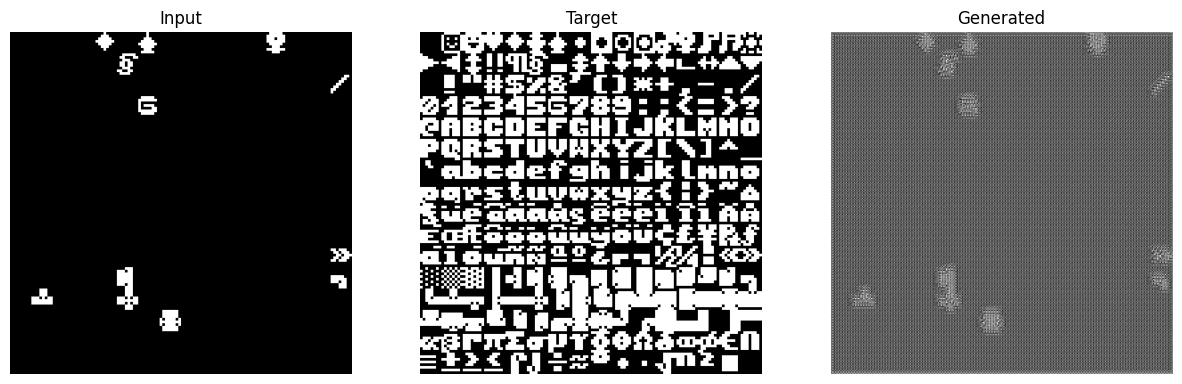

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from generator import Generator
from loader import load_dataset

def show_images(input_img, target_img, predicted_img):
    plt.figure(figsize=(15,5))

    display_list = [input_img[0], target_img[0], predicted_img[0]]
    title = ['Input', 'Target', 'Generated']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        img = display_list[i]
        img = (img + 1.0) / 2.0  # Back to [0,1] from [-1,1]
        plt.imshow(tf.squeeze(img), cmap='gray')
        plt.axis('off')

    plt.show()


# Build the generator
gen = Generator()

# Load some training data (this loads masked input + target)
dataset = load_dataset("training_pairs", batch_size=1, shuffle=True)

# Grab one sample
for input_image, target_image in dataset.take(1):
    print("Input shape:", input_image.shape)
    print("Target shape:", target_image.shape)

    # Run the generator
    generated_image = gen(input_image, training=False)

    print("Generated shape:", generated_image.shape)
    show_images(input_image, target_image, generated_image)

    break

The output looks like garbage. That's expected. The generator is untrained. Our AI needs to learn what is garbage and what not.


## Building the Discriminator

The discriminator discriminates the output of the generator. The snitch in our model
that constantly tells the Generator:

    “Your output is garbage, and I can tell. Try again.”

In Pix2Pix, the Discriminator’s job is to judge whether an image pair is:

🔵 Real → (input image, real target)

🔴 Fake → (input image, generated output)

It looks at both images together, and tells the Generator whether it believes the result is real or fake.

You can think of it like a really pissed-off font critic with a magnifying glass.

In Pix2Pix, a [PatchGAN]() discriminator is used.  Pix2Pix uses a PatchGAN discriminator:

It only looks at local 70×70 patches. This way, it is forced to focus on fine-grained detail. Are the pixels aligned, edges sharp, glyphs crisp?

It returns a grid of predictions (e.g. 30×30), not just one scalar. This way, the  Generator gets feedback pixel by pixel, not just globally.


### Inputs and outputs

 Inputs to the Discriminator
You pass in:

- The input image (masked font grid)
- The output image (either real target or generated guess)

It concatenates them along the channel axis → shape: (batch, 256, 256, 2)

It returns:

A tensor of shape ≈ (batch, 30, 30, 1)

Each patch is a 70×70 region with a real/fake confidence score


In [4]:
from discriminator import Discriminator

disc = Discriminator()
disc.summary()

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ target_image        │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_14      │ (None, 256, 256,  │          0 │ input_image[0][0… │
│ (Concatenate)       │ 2)                │            │ target_image[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_30       │ (None, 128, 128,  │      2,112 │ concatenate_14[0… │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_31       │ (None, 64, 64,    │    131,584 │ sequential_30[0]… │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_32       │ (None, 32, 32,    │    525,312 │ sequential_31[0]… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 34, 34,    │          0 │ sequential_32[0]… │
│ (ZeroPadding2D)     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 31, 31,    │  2,097,152 │ zero_padding2d[0… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 31, 31,    │      2,048 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_19      │ (None, 31, 31,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 33, 33,    │          0 │ leaky_re_lu_19[0… │
│ (ZeroPadding2D)     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 30, 30, 1) │      8,193 │ zero_padding2d_1… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,766,401 (10.55 MB)

 Trainable params: 2,764,609 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

## The Training Process

Now it's time to let the Generator and the Discriminator fight.

Each step:

- Generator produces a predicted output from masked input.
- Discriminator looks at (input, prediction) and says “FAKE!”.
- Discriminator also looks at (input, real) and says “REAL!”.
- We compute:
  - Discriminator loss: how well it separates real vs fake
  - Generator loss:
    - Adversarial loss: how well it fools the Discriminator
    - L1 loss: how close the output is to the real target


In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
from generator import Generator
from discriminator import Discriminator
from loader import load_dataset

# --- Init model & optimizers (run this once!) ---
try:
    generator
    discriminator
except NameError:
    generator = Generator()
    discriminator = Discriminator()
    gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    dataset = load_dataset("training_pairs", batch_size=1)